# Building a Feed-forward Neural Network using PyTorch 
Adapted from: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html & https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

---

## Training an image classifier to classify happy and sad faces

We will perform the following steps in order:

1. Load and normalizing the the ![NimStim Dataset of Facial Expressions](https://danlab7.wixsite.com/nimstim) using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import os

plt.ion()

### 1. Load and normalize NimStim Dataset of Facial Expressions

We will load our dataset using `torchvision` from the following file structure:
```
├── NN_Emotional_Faces_Classifier.ipynb
├── nim_stim
|   └── training
|          └── happiness
|          └── sadness
|   └── testing
|          └── happiness
|          └── sadness
```
The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
data_transforms = {
    'training': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'testing': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

data_dir = './nim_stim/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['training', 'testing']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                  for x in ['training', 'testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'testing']}
class_names = image_datasets['training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Let's view some of our images:

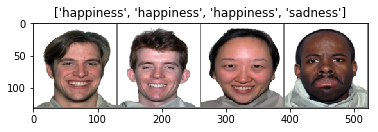

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 2. Define a Convolutional Neural Network

A typical training procedure for a neural network is as follows:
1. Define the neural network that has some learnable parameters (or weights)
2. Iterate over a dataset of inputs
3. Process input through the network
4. Compute the loss (how far is the output from being correct)
5. Propagate gradients back into the network’s parameters
6. Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient

Luckily, PyTorch let's us implement this fairly easily

In [4]:
#define the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*841, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), 16*841)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### 3. Define a Loss function and optimizer

Now that we've defined the network with a feed-forward function, let's specify the **loss function** to take the (output, target) pair of inputs, and compute a value that estimates how far away the output is from the target.

To backpropagate the error all we have to do is call `loss.backward()`. You need to clear the existing gradients though with `optimizer.zero_grad()`, or else gradients will be accumulated to existing gradients. When we call `loss.backward()`, the whole graph is differentiated w.r.t. the loss.

The package `torch.optim` implements all sorts of different update rules. For now, we will implement the simplest: Stochastic Gradient Descent (SGD): `weight = weight - learning_rate * gradient` using `optim.SGD()`.

In [5]:
criterion = nn.CrossEntropyLoss() #nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
num_epochs = 75

### 4. Train the network (where the magic happens)

We will loop over our data iterator, and feed the inputs to the network and optimize using our specified settings

In [6]:
import torch.nn as nn
import torch.nn.functional as F

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(dataloaders['training']):
#         inputs = inputs.to(device)
#         labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # forward
        
        loss = criterion(outputs, labels) # loss function defined above
        loss.backward() # backprop
        optimizer.step() 

        # print statistics
        running_loss += loss.item()
        if i % 18 == 0:    # print every 18th
            print('[%d] loss: %.3f' %
                  (epoch + 1, running_loss / 18))
            running_loss = 0.0

print('Finished Training')

Epoch 0/74
----------
[1] loss: 0.129
Epoch 1/74
----------
[2] loss: 0.112
Epoch 2/74
----------
[3] loss: 0.048
Epoch 3/74
----------
[4] loss: 0.032
Epoch 4/74
----------
[5] loss: 0.031
Epoch 5/74
----------
[6] loss: 0.072
Epoch 6/74
----------
[7] loss: 0.040
Epoch 7/74
----------
[8] loss: 0.032
Epoch 8/74
----------
[9] loss: 0.049
Epoch 9/74
----------
[10] loss: 0.040
Epoch 10/74
----------
[11] loss: 0.035
Epoch 11/74
----------
[12] loss: 0.033
Epoch 12/74
----------
[13] loss: 0.038
Epoch 13/74
----------
[14] loss: 0.039
Epoch 14/74
----------
[15] loss: 0.035
Epoch 15/74
----------
[16] loss: 0.037
Epoch 16/74
----------
[17] loss: 0.033
Epoch 17/74
----------
[18] loss: 0.076
Epoch 18/74
----------
[19] loss: 0.036
Epoch 19/74
----------
[20] loss: 0.038
Epoch 20/74
----------
[21] loss: 0.033
Epoch 21/74
----------
[22] loss: 0.052
Epoch 22/74
----------
[23] loss: 0.030
Epoch 23/74
----------
[24] loss: 0.039
Epoch 24/74
----------
[25] loss: 0.050
Epoch 25/74
-------

### 5. Test the network on the test data

We have trained the network for 50 passes over the training dataset. But we need to check if the network has learned anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

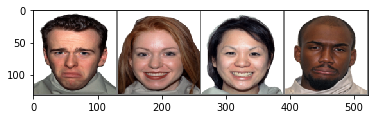

GroundTruth:  sadness happiness happiness sadness
Predicted:  sadness sadness happiness sadness


In [7]:
images, labels = next(iter(dataloaders['testing']))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(4)))

#### Magic! Way better than I expected! 
Let us look at how the network performs on the whole dataset.

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['testing']:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 91 %


And, there you have it! In this simple example, we can classify happy and sad faces with super high accuracy! *(better than some people)*